In [37]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras import layers

# ========== 1. DATA LOADING ==========
# Column names for NSL-KDD
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count',
    'serror_rate', 'srv_serror_rate', 'rerror_rate', 
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'difficulty'
]

# Load NSL_KDD dataset from github
# https://www.unb.ca/cic/datasets/nsl.html
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
df = pd.read_csv(url, header=None, names=column_names)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst rows:")
print(df.head())
print(f"\nLabel distribution:")
print(df['label'].value_counts())

Dataset shape: (125973, 43)

First rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60      

In [38]:
# ========== 2. PREPROCESSING ==========
# Remove difficulty column (if exists)
if 'difficulty' in df.columns:
    df = df.drop('difficulty', axis=1)

# Create binary label: normal = 0, attack = 1
df['is_attack'] = (df['label'] != 'normal').astype(int)
labels = df['is_attack'].values
df = df.drop('label', axis=1)

# Split into categorical and numeric features
categorical_cols = ['protocol_type', 'service', 'flag']
numeric_cols = [col for col in df.columns if col not in categorical_cols + ['is_attack']]

print(f"\nNumeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Encode categorical features
df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separate labels
X = df_encoded.drop('is_attack', axis=1).values
y = df_encoded['is_attack'].values

# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


Numeric features: 38
Categorical features: 3


In [39]:
# ========== 3. TRAINING AUTOENCODER ON NORMAL TRAFFIC ONLY ==========
# Key point: autoencoder learns from normal data only
X_train_normal = X_train[y_train == 0]
print(f"\nTraining examples (normal only): {len(X_train_normal)}")
print(f"Test examples (normal + attacks): {len(X_test)}")


Training examples (normal only): 53874
Test examples (normal + attacks): 25195


In [97]:
# ========== 4. AUTOENCODER ARCHITECTURE WITH NAMED LAYERS ==========
from keras.optimizers import AdamW

input_dim = X_train.shape[1]
encoding_dim = 10  # Latent representation size

# Build autoencoder with named layers
encoder_input = layers.Input(shape=(input_dim,), name='input')
encoded = layers.Dense(32, activation='gelu', name='encoder_dense')(encoder_input)
encoded = layers.Dense(24, activation='gelu', name='encoder_dense2')(encoded)
encoded = layers.Dense(encoding_dim, activation='gelu', name='latent_space')(encoded)

decoded = layers.Dense(16, activation='gelu', name='decoder_dense')(encoded)
decoded = layers.Dense(24, activation='gelu', name='decoder_dense2')(decoded)
decoded = layers.Dense(input_dim, activation='linear', name='reconstruction')(decoded)

# Create autoencoder model
autoencoder = keras.Model(encoder_input, decoded, name='autoencoder')
autoencoder.compile(optimizer=AdamW(), loss='mse')

print("\nAutoencoder architecture:")
autoencoder.summary()


Autoencoder architecture:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense (Dense)           │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (Dense)           │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense2 (Dense)          │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 41)             │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,995 (15.61 KB)

 Trainable params: 3,995 (15.61 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# ========== 5. TRAINING ==========
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6980 - val_loss: 0.4321
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4551 - val_loss: 0.3191
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3699 - val_loss: 0.2699
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3298 - val_loss: 0.2401
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2925 - val_loss: 0.2170
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2659 - val_loss: 0.2133
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2482 - val_loss: 0.2120
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2345 - val_loss: 0.2171
Epoch 9/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2166 - val_loss: 0.1925
Epoch 10/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2046 - val_loss: 0.1800
Epoch 11/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1870 - val_loss: 0.1638
Epoch 12/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [99]:
# ========== 6. EXTRACT EMBEDDINGS AND RECONSTRUCTIONS ==========
# Create model to extract latent representations (embeddings)
latent_model = keras.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer('latent_space').output
)

# Get embeddings for train and test sets
train_embeddings = latent_model.predict(X_train)
test_embeddings = latent_model.predict(X_test)

# Get reconstructions
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

print(f"\nEmbedding shape: {test_embeddings.shape}")
print(f"Original input shape: {X_test.shape}")

3150/3150 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Embedding shape: (25195, 10)
Original input shape: (25195, 41)


In [100]:
# ========== 7. ANOMALY DETECTION ==========
# Calculate reconstruction error
train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Define threshold (e.g., 95th percentile on training set)
threshold = np.percentile(train_mse, 95)
print(f"\nAnomaly detection threshold: {threshold:.4f}")

# Predict anomalies
y_pred = (test_mse > threshold).astype(int)


Anomaly detection threshold: 0.8508


In [101]:
# ========== 8. EVALUATION ==========
from sklearn.metrics import classification_report, confusion_matrix

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))


Confusion matrix:
[[13417    52]
 [10457  1269]]

Classification report:
              precision    recall  f1-score   support

      Normal       0.56      1.00      0.72     13469
      Attack       0.96      0.11      0.19     11726

    accuracy                           0.58     25195
   macro avg       0.76      0.55      0.46     25195
weighted avg       0.75      0.58      0.47     25195



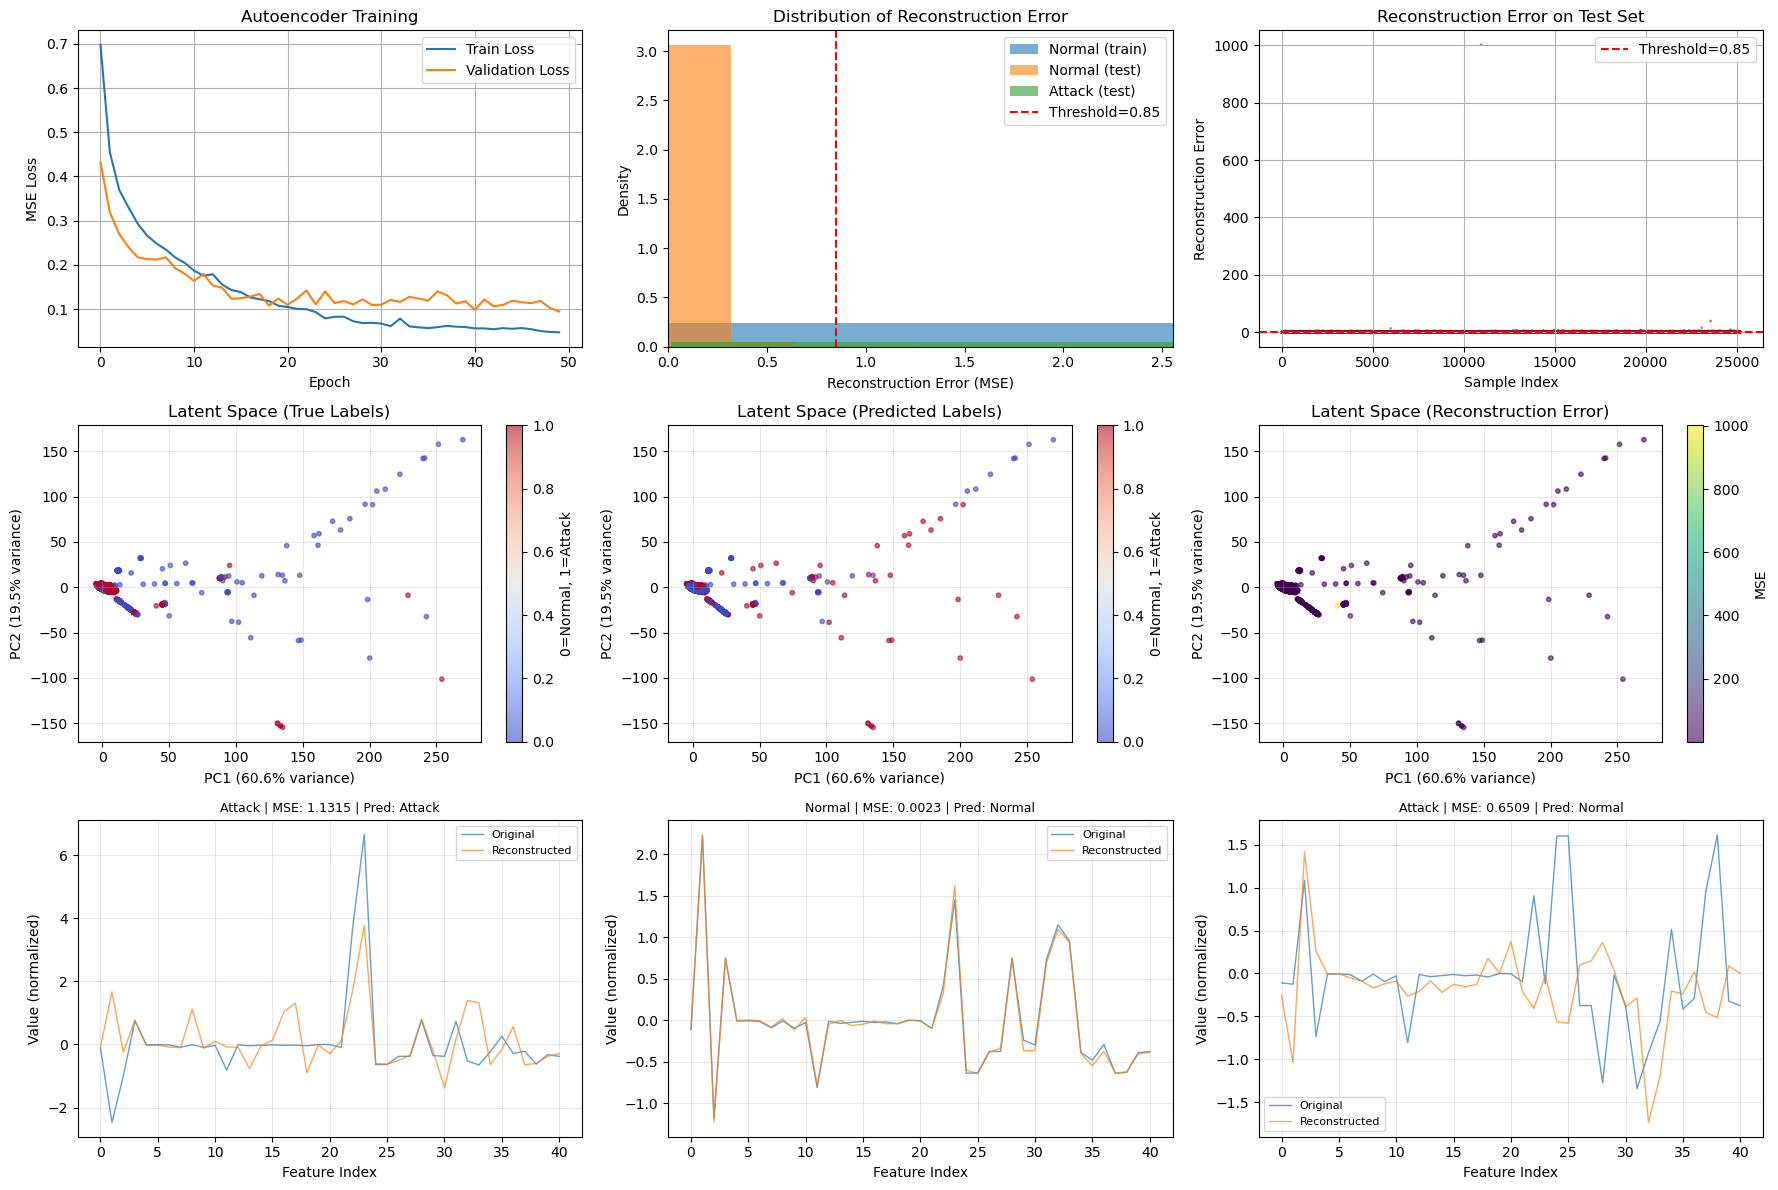

In [102]:
# ========== 9. VISUALIZATION ==========
fig = plt.figure(figsize=(18, 12))

# Plot 1: Loss during training
ax1 = plt.subplot(3, 3, 1)
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Autoencoder Training')
ax1.legend()
ax1.grid(True)

# Plot 2: Distribution of reconstruction error
ax2 = plt.subplot(3, 3, 2)
ax2.hist(train_mse[y_train == 0], bins=50, alpha=0.6, label='Normal (train)', density=True)
ax2.hist(test_mse[y_test == 0], bins=50, alpha=0.6, label='Normal (test)', density=True)
ax2.hist(test_mse[y_test == 1], bins=50, alpha=0.6, label='Attack (test)', density=True)
ax2.axvline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.2f}')
ax2.set_xlabel('Reconstruction Error (MSE)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Reconstruction Error')
ax2.legend()
ax2.set_xlim(0, min(threshold * 3, test_mse.max()))

# Plot 3: Reconstruction error for each sample
ax3 = plt.subplot(3, 3, 3)
ax3.scatter(range(len(test_mse)), test_mse, c=y_test, cmap='coolwarm', alpha=0.5, s=1)
ax3.axhline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.2f}')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Reconstruction Error')
ax3.set_title('Reconstruction Error on Test Set')
ax3.legend()
ax3.grid(True)

# Plot 4-5: Latent space visualization (2D projection using PCA)
# Reduce embeddings to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
test_embeddings_2d = pca.fit_transform(test_embeddings)
train_embeddings_2d = pca.transform(train_embeddings)

# Plot 4: Latent space colored by true labels
ax4 = plt.subplot(3, 3, 4)
scatter = ax4.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=10)
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax4.set_title('Latent Space (True Labels)')
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('0=Normal, 1=Attack')

# Plot 5: Latent space colored by predicted labels
ax5 = plt.subplot(3, 3, 5)
scatter = ax5.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], 
                      c=y_pred, cmap='coolwarm', alpha=0.6, s=10)
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax5.set_title('Latent Space (Predicted Labels)')
ax5.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax5)
cbar.set_label('0=Normal, 1=Attack')

# Plot 6: Latent space colored by reconstruction error
ax6 = plt.subplot(3, 3, 6)
scatter = ax6.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], 
                      c=test_mse, cmap='viridis', alpha=0.6, s=10)
ax6.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax6.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax6.set_title('Latent Space (Reconstruction Error)')
ax6.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('MSE')

# Plot 7-9: Example reconstructions
n_examples = 3
indices = np.random.choice(len(X_test), n_examples)

for i, idx in enumerate(indices):
    ax = plt.subplot(3, 3, 7 + i)
    original = X_test[idx]
    reconstructed = X_test_pred[idx]
    error = test_mse[idx]
    label = "Attack" if y_test[idx] == 1 else "Normal"
    
    ax.plot(original, label='Original', alpha=0.7, linewidth=1)
    ax.plot(reconstructed, label='Reconstructed', alpha=0.7, linewidth=1)
    ax.set_title(f'{label} | MSE: {error:.4f} | Pred: {"Attack" if error > threshold else "Normal"}', 
                 fontsize=9)
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Value (normalized)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

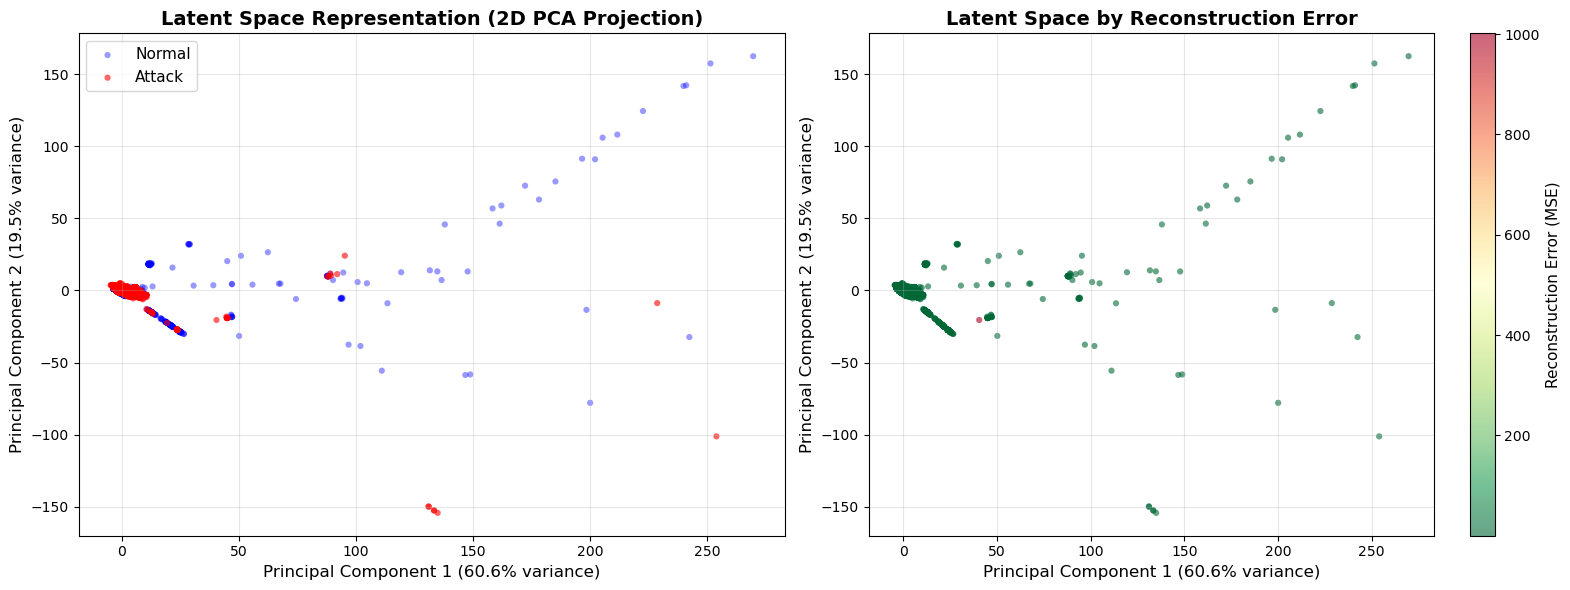

In [103]:
# ========== 10. DETAILED LATENT SPACE ANALYSIS ==========
# Create a separate detailed plot for latent space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot with larger points and better separation
ax1 = axes[0]
# Plot normal samples first (so they're in background)
normal_mask = y_test == 0
attack_mask = y_test == 1

ax1.scatter(test_embeddings_2d[normal_mask, 0], test_embeddings_2d[normal_mask, 1], 
           c='blue', alpha=0.4, s=20, label='Normal', edgecolors='none')
ax1.scatter(test_embeddings_2d[attack_mask, 0], test_embeddings_2d[attack_mask, 1], 
           c='red', alpha=0.6, s=20, label='Attack', edgecolors='none')
ax1.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax1.set_title('Latent Space Representation (2D PCA Projection)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot with contour showing density
ax2 = axes[1]
scatter = ax2.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], 
                     c=test_mse, cmap='RdYlGn_r', alpha=0.6, s=20, edgecolors='none')
ax2.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax2.set_title('Latent Space by Reconstruction Error', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Reconstruction Error (MSE)', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ========== HOW AUTOENCODER WORKS ==========

1. TRAINING: The autoencoder is trained ONLY on normal traffic.
   It learns to compress (encoder) and reconstruct (decoder) normal data.

2. LATENT REPRESENTATION (EMBEDDINGS): 
   - The encoder compresses {input_dim} features into {encoding_dim} numbers
   - This is accessed via the 'latent_space' layer
   - This "compressed code" contains key information about normal traffic
   - We can extract it: latent_model.predict(data)

3. RECONSTRUCTION:
   - The decoder tries to reconstruct the original input from the embeddings
   - This is the final output of the autoencoder
   - Good reconstruction = low MSE = likely normal traffic

4. ANOMALY DETECTION: When we feed an attack into the autoencoder:
   - It tries to reconstruct the data as if it were normal traffic
   - It does poorly → high reconstruction error (MSE)
   - If MSE > threshold → it's an anomaly!

5. LATENT SPACE VISUALIZATION:
   - We use PCA to project {encoding_dim}D embeddings to 2D
   - You can see that attacks (red) and normal traffic (blue) cluster differently
   - The autoencoder learned to separate them in the latent space!

6. THRESHOLD: We set the threshold at the 95th percentile of normal traffic.
   This means: 5% of normal examples will be falsely marked as attacks (FPR=5%).
""")